 ## **Clean the Data (deal with missing values):**

There are no missing values in this dataset, and each image has the exact same shape. From the website: "The CIFAR-10 dataset consists of *60000 32x32 colour images in 10 classes, with 6000 images per class.* There are **50000 training images and 10000 test images.**

*The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.* The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

For this reason, train/test splitting is already done intrinsically (by the owner of the CIFAR-10 dataset), and the data must simply be loaded and differentiated properly to be properly used.

## **Create/Implement a Custom Transformer:**

Each image starts as a 32x32x3 vector of data, containing the RGB values for each pixel in a 32x32 image one after another. To be used in most machine learning algorithms, each image must be one single instance (row). Thus, each image will be reshaped to one vector of (32 * 32 * 3) = 3072 values.

In [5]:
#eloquent solution on stack overflow:
#https://stackoverflow.com/questions/37512290/reading-cifar10-dataset-in-batches

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

%matplotlib inline


img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6): #there are five files (data_batch_1 through data_batch_5)
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-python.tar\cifar-10-python\cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


## Use OvO or OvR classifier:

One of the most common approaches to machine learning multiclass problems is training several binary classifiers against each other and taking the best result. The two methods that utilize this are OvO (one versus one) and OvR (one versus rest). When using binary methods (like Support Vector Machines) against multiclass data/problems, certain packages will intrinsically create an OvO/OvR model to match.

In [2]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(x_train, y_train)

svm.predict(x_train[0].reshape(1,-1))

array([6])

In [3]:
#To prove that it is using OvO/OvR under the hood:
some_animal_scores = svm.decision_function(x_train[0].reshape(1,-1))

In [21]:
some_animal_scores
#So, the classifier thinks this is a frog:

array([[ 3.07273466,  1.88822817,  4.2008428 ,  8.29665454,  6.26010439,
         5.25895913,  9.30484929,  7.27992063, -0.31802072,  0.69314936]])

6

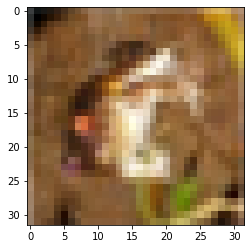

In [22]:
#let's see what the image actually is, visually
import matplotlib.pyplot as plt

image = x_train[0, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[0]

In [ ]:
#It is indeed a frog, just as the classifier had expected

#Let's try another model and see if this can also get it right

 ## **Use sklearn.neighbors.KNeighborsClassifier:**

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
#As an initial test, let's use the default for K in sci-kit learn's KNN algorithm (k = 5)
knn = KNeighborsClassifier(n_neighbors=5)

In [9]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [7]:
#testing on a single sample
knn.predict(x_train[0].reshape(1,-1))

array([4])

In [8]:
knn.predict_proba(x_train[0].reshape(1,-1))

array([[0. , 0. , 0.2, 0. , 0.6, 0. , 0.2, 0. , 0. , 0. ]])

In [9]:
#class labels =  airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
#So, the classifier thinks this is a deer

6

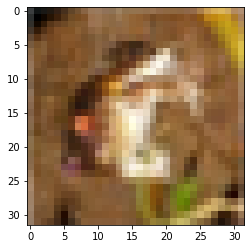

In [10]:
#let's see what the image actually is, visually
import matplotlib.pyplot as plt

image = x_train[0, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[0]

In [11]:
#this appears to be a frog (class 6), not a deer (class 4)
#Was this just a fluke, though, or are none of the predictions particularly accurate?

In [12]:
from sklearn.model_selection import cross_val_score
mae_A = cross_val_score(knn, x_val, y_val, scoring="neg_mean_absolute_error", cv=10)

In [13]:
mae = mae_A.mean()
stdAccuracy = mae_A.std()
print("Mean Absolute Error: %.2f, Standard Deviation : %.2f" % (mae, stdAccuracy))

Mean Absolute Error: -2.76, Standard Deviation : 0.28


In [14]:
accuracy = cross_val_score(knn, x_val, y_val, scoring="accuracy", cv=10)
print("Accuracy: %.2f, Standard Deviation: %.2f" % (accuracy.mean(), accuracy.std()))

Accuracy: 0.22, Standard Deviation: 0.04


At least it's *consistently* wrong, right? Is there anything we can assess to figure out *why* it is performing so poorly?

## Generate a confusion matrix

- "Each row in a confusion matrix represents an actual class, while each column represents a predicted class."
- "For example, to know the number of times the classifier confused images of the fifth class with the third one, you would look in the **fifth row and third column** of the confusion matrix."

In [10]:
from sklearn.model_selection import cross_val_predict

#Generate prediction scores
y_train_pred = cross_val_predict(knn, x_val, y_val, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_train_pred)

array([[34,  2, 16,  2,  3,  1,  2,  1, 26,  0],
       [15, 13, 19,  8, 19,  3, 15,  3, 20,  4],
       [11,  1, 28,  4, 12,  4, 13,  1,  5,  0],
       [17,  4, 36, 16, 12,  3, 14,  0,  8,  2],
       [ 8,  1, 28,  1, 22,  2, 12,  0,  4,  0],
       [13,  0, 30,  6, 18, 11, 15,  2,  3,  0],
       [ 7,  1, 41,  4, 23,  1, 23,  2,  0,  0],
       [10,  1, 36, 10, 18,  3,  6, 12, 10,  1],
       [15,  1, 15,  1,  4,  3,  4,  1, 69,  0],
       [21,  4, 24,  7,  5,  1,  4,  3, 33,  3]], dtype=int64)

The class labels are *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*

So, the most understood classes were the ships (class 9), airplanes (class 1), and birds (class 3). Why is that?

8

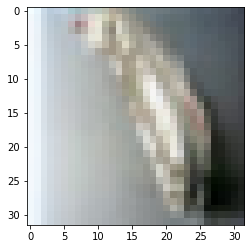

In [22]:
#Ship example
image = x_train[2003, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[2003]

0

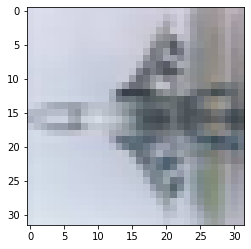

In [56]:
#Airplane example
image = x_train[284, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[284]

2

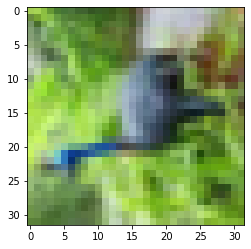

In [26]:
#bird example
image = x_train[6, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[6]

These three classes seem to be somewhat intuitively "easier" to understand as compared to certain classes (dogs, cats, and horses are harder to differentiate- being all quadrupedal classes). However, oddly, there are also a lot of different types of pictures *confused as birds, airplanes, and ships*, as opposed to the other classes. This makes you wonder if the algorithm is potentially learning to classify too many different things as these three classes instead of attempting to differentiating between all ten different classes.

Before we attempt to make the KNN model better and tune its parameters with something like GridSearch, let's check one more piece of the current model- the ROC curve, which compares true positive and false positive rates.

## Generate a ROC Curve or related

In [ ]:
#Since ROC curves are for single class only, we need to plot as OvR
#fortunately, there exist libraries and functions that help with this
#https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(knn, x_train, y_train, n_classes=10, figsize=(16, 10))

## **Use Grid Search CV or RandomizedSearch CV to tune hyperparameters for a model**

In [15]:
#training with grid-search from https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/
from sklearn.model_selection import GridSearchCV
ks = list(range(1, 31)) #past 20-30 is too much energy for this jupyter instance
param_grid = dict(n_neighbors=ks)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [16]:
print("Best Accuracy is ", grid_search.best_score_*100, " with a k value of ", grid_search.best_params_)

Best Accuracy is  34.33673469387755  with a k value of  {'n_neighbors': 1}


Based on our gridsearch, our best value for K is 1.

Now, with this model, we can test and deploy it.

## **Evaluate your system on the Test Data**

In [3]:
knn_updated = KNeighborsClassifier(n_neighbors=1)

In [6]:
knn_updated.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [19]:
mae_B = cross_val_score(knn_updated, x_test, y_test, scoring="neg_mean_absolute_error", cv=10)
mae_updated = mae_B.mean()
stdAccuracy_updated = mae_B.std()
print("Mean Absolute Error: %.2f, Standard Deviation : %.2f" % (mae_updated, stdAccuracy_updated))

Mean Absolute Error: -2.41, Standard Deviation : 0.06


In [20]:
accuracy_updated = cross_val_score(knn_updated, x_test, y_test, scoring="accuracy", cv=10)
print("Accuracy: %.2f, Standard Deviation: %.2f" % (accuracy_updated.mean(), accuracy_updated.std()))

Accuracy: 0.29, Standard Deviation: 0.01


Optimizing our parameters with GridSearch lowered our MAE from 2.76 to 2.41 and raised our accuracy from 22% to 29%, an increase of over 30% in accuracy and a 15% decrease in MAE.